**Study Objectives**

The study seeks to answer the following questions:
1. What is the impact of the shape of the token distribution on the shape of the final group ticket distribution?
2. What is the Likelihood of a >51% group ownership?
3. Is the SHA256# truly uniformly distributed (Promethea - "if this is not true then we can make a lot of money" :))

We attempt to answer these questions in the following ways:
* We use a uniformly distributed set of ticket random numbers (assuming the SHA256 is uniformly distributed) and assign ownership based on several different ticket distributions, and then select a subset of minimum value into a "group"
* We assume that if the shape of the ticket distribution in the group over several runs is similar to the distribution of ticket ownership it proves that the ticket ownership distribution has an impact on the final group
* We guage the extent of the impact by determining the maximum percentage ownership of a group with respect to the maximum ticket ownership
* We estimate the likelihood of >51% ownership by counting the number of times such a level is achieved in multiple runs.

What-If analysis for the following Token distributions:
* Linear - max 2%
* Stepped - max 10%, 25%, 40%

**Ticket Generation and Threshold selection**
We use numpy's random function to generate a uniform distribution of tickets. We then iteratively determine the min threshold required for the specified group size. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Function used to find the index values of tickets in a group
def min_index(ticket_array, group_size):
    array = copy.deepcopy(ticket_array)
    group = sorted(array)[0:group_size] # generates a sorted list of min values of length = group size
    #print(group)
    indexes = [] #initializes the array of indexes for min ticket values
    
    for ticket in group: # iterates through each ticket value in the sorted list
        
        ticket_index = np.where(array==(ticket)) #finds the index with the ticket value
        #print("ticket_index = " + str(ticket_index))
        indexes.append(ticket_index[0][0]) # adds the index value to the array of indexes
        #print("indexes = " + str(indexes))
        array[ticket_index[0][0]] = 1 #sets the vaue at that index to the max value of 1 to address the problem of repeatd values
        
    #print(ticket_array_temp)
    return sorted(indexes)


In [6]:
# Global Variables
group_size = 100 # Group size
runs = 1000 # number of runs/cycles
total_tickets = 50000 # total virtual stakers
nodes = 100 # number of nodes
tickets = [] # initializing the array that will contain the tickets
group_members = [] # initializing the array that will contain indexes(node #) of tickets for each group



In [7]:
# Pre-processing ticket arrays & group members for each run to reduce sim time
for i in range(0, runs):
    tickets.append(np.random.random_sample(int(total_tickets)))

In [8]:
# Pre-processing groups
for i in range(0, runs):
    group_members.append(min_index(tickets[i],group_size)) # finds the index of group members with min ticket values



50000.0


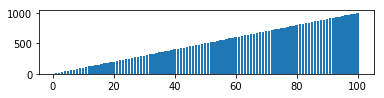

In [14]:
# Pre-processing distributions for total tickets = 50000
# Linear y = m * (x + 1) since indices start from 0
L02 = np.zeros(nodes) 

for i in range (0,nodes):
    L02[i] =  10 * (i + 1) # m = 50 gives max y as 1000 which is 2% of 50000

x = np.linspace(1,nodes,nodes)
plt.subplot(3, 1, 1)
plt.bar(x, L02)

print(sum(L02-5))

<BarContainer object of 100 artists>

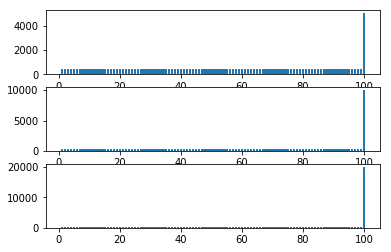

In [15]:
# Pre-processing distributions for total tickets = 50000
# Step 
S10 = np.empty(nodes)
S10.fill(round(45000/(nodes-1)))
S10[nodes-1] = 5000
plt.subplot(3, 1, 1)
plt.bar(x, S10)

S25 = np.empty(nodes)
S25.fill(round(40000/(nodes-1)))
S25[nodes-1] = 10000
plt.subplot(3, 1, 2)
plt.bar(x, S25)

S40 = np.empty(nodes)
S40.fill(round(30000/(nodes-1)))
S40[nodes-1] = 20000
plt.subplot(3, 1, 3)
plt.bar(x, S40)

In [17]:
# Create CDF's - used to determine max ownership ticket index

def create_cdf(nodes,ticket_distr):
    cdf = np.zeros(nodes)
    for node,ticketmax in enumerate(ticket_distr):
        cdf[node]=sum(ticket_distr[0:node+1])
    return cdf

cdf_L02 = create_cdf(nodes,L02)
cdf_S10 = create_cdf(nodes,S10)
cdf_S25 = create_cdf(nodes,S25)
cdf_S40 = create_cdf(nodes,S40)

#print(cdf_L02)
#print(cdf_S10)
#print(cdf_S25)
#print(cdf_S40)


Linear 2% max, Max ownership = 0.1
Linear 2% max, Max # 51% ownership = 0.0
Step 10% max, Max ownership = 0.21
Step 10% max, Max # 51% ownership = 0.0
Step 25% max, Max ownership = 0.33
Step 25% max, Max # 51% ownership = 0.0
Step 40% max, Max ownership = 0.55
Step 40% max, Max # 51% ownership = 0.015


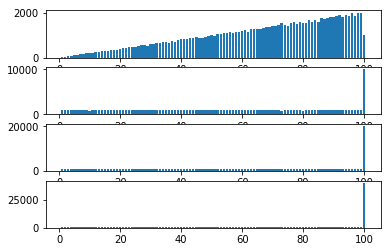

In [18]:

# function to calculate group ownership distribution
def group_distr(runs, nodes, group_members, cdf):
    total_group_distr = np.zeros(nodes)
    max_owned = np.zeros(runs)
    for i in range(0,runs):
        group_distr = np.zeros(nodes)
        group_distr[0] = sum(group_members[i]<cdf[0])
        for j in range(1,nodes):
            group_distr[j] = sum(group_members[i]<cdf[j])-sum(group_members[i]<cdf[j-1])
        max_owned[i] = max(group_distr)/sum(group_distr)
        total_group_distr +=group_distr
    return total_group_distr, max_owned, group_distr

# calculate group ownership distributions for n runs
# Linear
distr_L02, max_owned_L02, vect_L02 = group_distr(runs, nodes, group_members, cdf_L02)
plt.subplot(4, 1, 1) 
plt.bar(x, distr_L02)

distr_S10, max_owned_S10, vect_S10 = group_distr(runs, nodes, group_members, cdf_S10)
plt.subplot(4, 1, 2) 
plt.bar(x, distr_S10)

distr_S25, max_owned_S25, vect_S25 = group_distr(runs, nodes, group_members, cdf_S25)
plt.subplot(4, 1, 3) 
plt.bar(x, distr_S25)

distr_S40, max_owned_S40, vect_S40 = group_distr(runs, nodes, group_members, cdf_S40)
plt.subplot(4, 1, 4) 
plt.bar(x, distr_S40)

print("Linear 2% max, Max ownership = "+ str(max(max_owned_L02)))
print("Linear 2% max, Max # 51% ownership = "+ str(sum(max_owned_L02>0.5)/runs))
print("Step 10% max, Max ownership = "+ str(max(max_owned_S10)))
print("Step 10% max, Max # 51% ownership = "+ str(sum(max_owned_S10>0.5)/runs))
print("Step 25% max, Max ownership = "+ str(max(max_owned_S25)))
print("Step 25% max, Max # 51% ownership = "+ str(sum(max_owned_S25>0.5)/runs))
print("Step 40% max, Max ownership = "+ str(max(max_owned_S40)))
print("Step 40% max, Max # 51% ownership = "+ str(sum(max_owned_S40>0.5)/runs))



**Testing**

In [55]:
# Value Checks

50000


In [156]:
# testing the min index function
a = np.random.random_sample(10)
c = a
a = np.append(a,np.min(a))
a = np.append(a,np.min(a))
a = np.append(np.min(a),a)
print(a)
b = min_index(a, 4)
print(b)


[0.06343352 0.9429842  0.74289453 0.46358071 0.13515092 0.80616356
 0.32077941 0.53155799 0.67517553 0.87720912 0.06343352 0.06343352
 0.06343352]
[0.06343352347826425, 0.06343352347826425, 0.06343352347826425, 0.06343352347826425]
ticket_index = (array([ 0, 10, 11, 12]),)
indexes = [0]
ticket_index = (array([10, 11, 12]),)
indexes = [0, 10]
ticket_index = (array([11, 12]),)
indexes = [0, 10, 11]
ticket_index = (array([12]),)
indexes = [0, 10, 11, 12]
[1.         0.9429842  0.74289453 0.46358071 0.13515092 0.80616356
 0.32077941 0.53155799 0.67517553 0.87720912 1.         1.
 1.        ]
[0, 10, 11, 12]


In [31]:
# testing the min index function
a = np.random.random_sample(20)
print(a)
b = min_index(a, 5)
print(a)
print(a[b[0]])
print(a[b[-1]])
print(sum(a<=a[b[-1]]))

[0.35159272 0.76207269 0.75798182 0.60031978 0.64440427 0.26717531
 0.82531014 0.03046798 0.11825377 0.26868173 0.74413926 0.19232398
 0.29635666 0.87383097 0.13044544 0.3394168  0.86215274 0.66847409
 0.2679212  0.95484219]
[0.35159272 0.76207269 0.75798182 0.60031978 0.64440427 0.26717531
 0.82531014 0.03046798 0.11825377 0.26868173 0.74413926 0.19232398
 0.29635666 0.87383097 0.13044544 0.3394168  0.86215274 0.66847409
 0.2679212  0.95484219]
0.030467981228564978
0.26717531377727566
5
